In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file
from threeML.io import update_logging_level
from threeML.utils.data_download.Fermi_LAT.download_LAT_data import LAT_dataset
from astropy.io import fits as pyfits

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# This if you want to toggle different type of logging level.
update_logging_level("INFO")
log.error("error")
log.info("info")
log.debug("debug")

01:54:49 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=728768;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=154449;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=546671;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=289335;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=313470;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=904378;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

01:54:51 ERROR     error                                                                           ]8;id=316821;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9380/3699701126.py\3699701126.py]8;;\:]8;id=621821;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9380/3699701126.py#29\29]8;;\

         INFO      info                                                                            ]8;id=296932;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9380/3699701126.py\3699701126.py]8;;\:]8;id=558453;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9380/3699701126.py#30\30]8;;\

## GtBurst
Gtburst contains all the classes and methods to perform Fermi LAT data. It internally uses the official fermitools software. Here an example to list the IRFS available:


In [2]:
from GtBurst import IRFS

irfs = IRFS.IRFS.keys()
print(irfs)

odict_keys(['p7rep_transient', 'p7rep_source', 'p7rep_clean', 'p7rep_ultraclean', 'p8r2_transient100e', 'p8r2_transient100', 'p8r2_transient020e', 'p8r2_transient020', 'p8r2_transient010e', 'p8r2_transient010', 'p8r2_source', 'p8r2_clean', 'p8r2_ultraclean', 'p8r2_ultracleanveto', 'p8r2_transient100s', 'p8r2_transient015s', 'p8_transient100e', 'p8_transient100', 'p8_transient020e', 'p8_transient020', 'p8_transient010e', 'p8_transient010', 'p8_source', 'p8_clean', 'p8_ultraclean', 'p8_ultracleanveto', 'p8_sourceveto', 'p8_transient100s', 'p8_transient015s'])


## The LAT Transient Builder
Let's see how to make a plug in for the unbinned analysis of Fermi LAT data. First we use the information form a triggered GRB to obtain MET, RA and DEC, that are needed for the analysis.


In [3]:
from GtBurst.TriggerSelector import TriggerSelector

myFavoriteGRB = "bn190114873"


def findGRB(grb_name):
    a = TriggerSelector()
    a.downloadList()
    myGRB = {}
    for x in a.data:
        if x[0] == myFavoriteGRB:
            myGRB["MET"] = float(x[1])
            myGRB["RA"] = float(x[3])
            myGRB["DEC"] = float(x[4])
            myGRB["ERR"] = float(x[5])
            return myGRB
            pass
    return None

In [4]:
myGRB = findGRB(myFavoriteGRB)
print(myGRB)

{'MET': 569192227.626, 'RA': 54.51, 'DEC': -26.939, 'ERR': 0.05}


Then, we download LAT data and we build the transient builder, we want to analyze 1000 seconds since the trigger. Let's start download the data:


In [5]:
tstart = 0
tstop = 1000

In [6]:
myLATdataset = LAT_dataset()

myLATdataset.make_LAT_dataset(
    ra=myGRB["RA"],
    dec=myGRB["DEC"],
    radius=12,
    trigger_time=myGRB["MET"],
    tstart=tstart,
    tstop=tstop,
    data_type="Extended",
    destination_directory=".",
    Emin=100.0,
    Emax=10000.0,
)  # Energies are MeV (this is from 100 MeV to 10 GeV)

01:55:04 INFO      Query parameters:                                                       ]8;id=505017;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=364147;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#262\262]8;;\

         INFO                          coordfield = 54.5100,-26.9390                       ]8;id=755569;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=628568;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         coordsystem = J2000                                  ]8;id=732606;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=19223;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          shapefield = 12                                     ]8;id=514964;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=89310;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                           timefield = 569192227.626,569193227.626            ]8;id=505507;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=896088;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                            timetype = MET                                    ]8;id=557891;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=815807;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         energyfield = 100.000,10000.000                      ]8;id=796503;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=557117;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO              photonOrExtendedOrNone = Extended                               ]8;id=534165;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=378411;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         destination = query                                  ]8;id=771869;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=166717;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          spacecraft = checked                                ]8;id=152091;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=251811;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO      Query ID: 86ad4d2b3b3e5065f0f0a976e6fc8315                              ]8;id=54233;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=241945;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#271\271]8;;\

01:55:05 INFO      Estimated complete time for your query: 15 seconds                      ]8;id=673454;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=426998;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#428\428]8;;\

         INFO      If this download fails, you can find your data at                       ]8;id=76876;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=44622;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#437\437]8;;\
                  https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/QueryResults.cgi?id=L2402082                         
                  055064996CEF234 (when ready)                                                                     

01:55:23 INFO      Downloading FT1 and FT2 files...                                        ]8;id=187959;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=720914;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#527\527]8;;\

01:55:28 WARNING   Only one FT1 file provided. Skipping the merge...                        ]8;id=256411;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=250104;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#98\98]8;;\

Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.rsp...
time -p gtselect infile=./bn190114873/gll_ft1_tr_bn190114873_v00.fit outfile=__temp_ft1.fits ra=54.51 dec=-26.939 rad=15.0 tmin=569192226.626 tmax=569193228.626 emin=10.0 emax=300000.0 zmin=0.0 zmax=110.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.13
user 0.10
sys 0.03
Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.pha...
 *  Get energy binning from the response matrix...

    done.

 *  Run gtbindef and gtbin and bin in energy and time...

time -p gtbindef bintype="E" binfile=__ebins.txt outfile=__energyBins.fits energyunits="keV" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbindef version HEAD
real 0.19
user 0.02
sys 0.01
time -p gtbin evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/__temp_ft1.fits scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=__gtllebin__pha2.pha algorithm="PHA2" ebinalg="FILE" emin=30.0 emax=200000.0 ebinfile=__energyBins.fits tbinalg="LIN" tstart=569192227.626 tstop=569193227.626 dtime=4.096 tbinfile=NONE coordsys="CEL" axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=1 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD


real 2.59
user 2.29
sys 0.29

    done.

 *  Transform gtbin output in CSPEC format...

    done.

 *  Updating keywords in the headers of the CSPEC file...

    done.

gtllebin done!


We want perform a time resolved analysis. So, first we look at the data. We can play with the ROI selection and the cut.


In [7]:
roi = 10
zmax = 110.0
thetamax = 180.0
irfs = "p8_transient020e"
strategy = "time"
myLATdataset.extract_events(roi, zmax, irfs, thetamax, strategy="time")

time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit evtable="EVENTS" outfile="gll_ft1_tr_bn190114873_v00_mkt.fit" apply_filter=yes overwrite=no header_obstimes=yes tstart=569192227.626 tstop=569193227.626 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 0.11
user 0.07
sys 0.03

Using 305 data

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192227.626 tmax=569193227.626 emin=100.0 emax=10000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=

Done.
real 0.13
user 0.10
sys 0.03

Selected 251 events.


01:55:31 INFO      Extracted 251 events                                                    ]8;id=65211;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=228668;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#670\670]8;;\

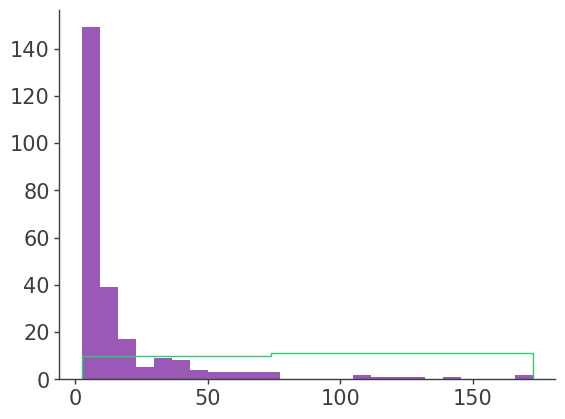

In [8]:
%matplotlib inline
event_file = pyfits.open(myLATdataset.filt_file)
event_times = sorted(event_file["EVENTS"].data["TIME"] - myGRB["MET"])
intervals = event_times[0::10]
_ = plt.hist(event_times)
_ = plt.hist(event_times, intervals, histtype="step")
# plt.show()

tstarts and tstops are defined as strings, with somma separated values for the starts and the ends of the time bins: For example tsrats="0,1,10" and tstops="1,10,20". To convert arrays in string we use these few lines of code:


In [9]:
tstarts = tstops = ""
for t0, t1 in zip(intervals[:-1], intervals[1:]):
    tstarts += "%.4f," % t0
    tstops += "%.4f," % t1
    pass
tstarts = tstarts[:-1].replace("-", "\\-")
tstops = tstops[:-1].replace("-", "\\-")

We can now make an instance the LAT transient builder


In [10]:
analysis_builder = TransientLATDataBuilder(
    myLATdataset.grb_name,
    outfile=myLATdataset.grb_name,
    roi=roi,
    tstarts=tstarts,
    tstops=tstops,
    irf=irfs,
    zmax=zmax,
    galactic_model="template",
    particle_model="isotr template",
    datarepository=".",
)
df = analysis_builder.display(get=True)

outfile                                                       190114873
roi                                                                  10
tstarts               2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.54...
tstops                3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.98...
zmax                                                              110.0
emin                                                              100.0
emax                                                           100000.0
irf                                                    p8_transient020e
galactic_model                                                 template
particle_model                                           isotr template
source_model                                                  PowerLaw2
tsmin                                                              20.0
strategy                                                           time
thetamax                                                        

In [11]:
tstops

'3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754'

The run method will run (using gtburst) all the fermitools needed to obtain the needed file for the likelihood analysis (livetimecubes, exposure maps. It will also perfom a simple likelihood analysis with the standard likelihood of the fermitools (pylikelihood). The dataproducts created here will be used by threeML to make the fit.


In [12]:
LAT_observations = analysis_builder.run(include_previous_intervals=True)

Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/scripts/doTimeResolvedLike.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtdiffrsp_mp.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtexpmap_mp.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtltcube_mp.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gttsmap_mp.py


01:55:32 INFO      About to run the following command:                                 ]8;id=592852;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=896898;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#636\636]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py 190114873 --outfile                                  
                  '190114873' --roi 10.000000 --tstarts                                                            
                  '2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.68                             
                  89,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165                             
                  ,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262' --tstops                                       
                  '3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.01                             
                  17,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.783                             
                  4,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754' --zmax                                       
                  110.000000 --emin 100.000000 --emax 100000.000000 --irf                                          
                  'p8_transient020e' --galactic_model 'template' --particle_model                                  
                  'isotr template' --source_model 'PowerLaw2' --tsmin 20.000000                                    
                  --strategy 'time' --thetamax 180.000000 --spectralfiles 'no'                                     
                  --liketype 'unbinned' --optimizeposition 'no' --datarepository '.'                               
                  --ltcube '' --expomap '' --ulphindex -2.000000 --flemin 100.000000                               
                  --flemax 10000.000000 --fgl_mode 'fast'                                                          

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   25.19240     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .29E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.71579     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .58E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Requested intervals:
------------------------------------------------------
2.6996               - 3.6358
3.6358               - 3.9968
3.9968               - 4.4024
4.4024               - 4.7375
4.7375               - 5.0909
5.0909               - 5.5471
5.5471               - 5.9896
5.9896               - 6.3998
6.3998               - 6.6889
6.6889               - 7.0117
7.0117               - 7.2936
7.2936               - 7.7731
7.7731               - 8.2167
8.2167               - 8.8763
8.8763               - 9.6573
9.6573               - 10.568
10.568               - 12.0568
12.0568              - 14.6165
14.6165              - 17.7834
17.7834              - 21.4962
21.4962              - 30.0798
30.0798              - 40.8747
40.8747              - 48.7118
48.7118              - 73.7262
73.7262              - 172.5754

Data files:
-----------
eventfile            /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit
ft2file      

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   4.786573     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   5.901543     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .70E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_3.6358-3.9968.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 8.12
user 7.46
sys 0.64
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.43105     FROM MIGRAD    STATUS=CONVERGED     67 CALLS       68 TOTAL
                     EDM=   .19E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   11.37565     FROM MIGRAD    STATUS=CONVERGED     74 CALLS       75 TOTAL
                     EDM=   .16E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  9.4%

  EXT PARAMETER                            

Total time in Good Time Intervals:        0.3350999355316162
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_4.4024-4.7375.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' source_model='PowerLaw2'

Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_4.4024-4.7375.xml 0.3350999355316162 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   7.632503     FROM MIGRAD    STATUS=CONVERGED     61 CALLS       62 TOTAL
                     EDM=   .99E-06  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  5.3%

  EXT PARAMETER                            

time -p gtsrcprob evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval4.7375-5.0909/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" outfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval4.7375-5.0909/gll_ft1_tr_bn190114873_v00_filt_prob.fit srcmdl=gll_ft1_tr_bn190114873_v00_filt_likeRes.xml irfs="CALDB" evtype="INDEF" srclist= chatter=2 clobber=yes debug=no gui=no mode="ql"
real 6.74
user 6.10
sys 0.63


Interval # 6 (5.0909-5.5471):
-----------------------

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_5.0909-5.5471.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn19011

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   10.79486     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .15E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   6.844639     FROM MIGRAD    STATUS=CONVERGED     66 CALLS       67 TOTAL
                     EDM=   .31E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval5.5471-5.9896/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 7.51
user 6.87
sys 0.63
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval5.5471-5.9896/gll_ft1_tr_bn190114873_v00_filt.fit
Spacecraft file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
Exposure map: gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Exposure cube: gll_ft1_tr_bn190114873_v00_filt_ltcube.fit
IRFs: P8R3_TRANSIENT020E_V3
Source model file: 190114873_LAT_xmlmodel_5.5471-5.9896.xml
Optimizer: Minuit

Performing likelihood fit...
Data  10.0
srcName  2.576925063095601e-06
srcName  10.000748366300273
srcName  0.0005360043373690395
srcName  0.00012916130

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   8.317516     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .68E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   12.58093     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .10E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure()


Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templates/FornaxA.fits...
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using spatial model SpatialMap...
Kept 1 point sources from the FGL catalog
-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_6.3998-6.6889.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_6.3998-6.6889.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.3998-6.6889/gll_ft1_tr_bn190114873_v00_filt.fit" evtable

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   18.30164     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_7.0117-7.2936.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='7.0117' tstop='7.2936' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   14.90094     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .44E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   13.18701     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .24E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.5%

  EXT PARAMETER                            

adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval7.2936-7.7731/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 7.82
user 7.17
sys 0.63
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval7.2936-7.7731/gll_ft1_tr_bn190114873_v00_filt.fit
Spacecraft file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
Exposure map: gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Exposure cube: gll_ft1_tr_bn190114873_v00_filt_ltcube.fit
IRFs: P8R3_TRANSIENT020E_V3
Source model file: 190114873_LAT_xmlmodel_7.2936-7.7731.xml
Optimizer: Minuit

Performing likelihood fit...
Data  10.0
sr

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   24.59086     FROM MIGRAD    STATUS=CONVERGED     57 CALLS       58 TOTAL
                     EDM=   .13E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   28.24928     FROM MIGRAD    STATUS=CONVERGED     56 CALLS       57 TOTAL
                     EDM=   .18E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_8.2167-8.8763.xml 0.659600019454956 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templates/FornaxA.fits...
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using spatial model SpatialMap...
Kept 1 point sources from the FGL catalog
-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_8.2167-8.8763.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_d

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   29.59265     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .12E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_9.6573-10.568.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='9.6573' tstop='10.568' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   30.55516     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .11E-04  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.1%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   29.31981     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .64E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  3.9%

  EXT PARAMETER                            

adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval10.568-12.0568/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 7.64
user 6.97
sys 0.65
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval10.568-12.0568/gll_ft1_tr_bn190114873_v00_filt.fit
Spacecraft file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
Exposure map: gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Exposure cube: gll_ft1_tr_bn190114873_v00_filt_ltcube.fit
IRFs: P8R3_TRANSIENT020E_V3
Source model file: 190114873_LAT_xmlmodel_10.568-12.0568.xml
Optimizer: Minuit

Performing likelihood fit...
Data  10.0

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   38.58473     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .91E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  4.2%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   41.85635     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .15E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_14.6165-17.7834.xml 3.1669000387191772 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templates/FornaxA.fits...
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using spatial model SpatialMap...
Kept 1 point sources from the FGL catalog
-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_14.6165-17.7834.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   40.63160     FROM MIGRAD    STATUS=CONVERGED     71 CALLS       72 TOTAL
                     EDM=   .94E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_21.4962-30.0798.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='21.4962' tstop='30.0798' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   34.58971     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .11E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   51.56070     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval30.0798-40.8747/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_30.0798-40.8747.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval30.0798-40.8747/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 7.40
user 6.75
sys 0.63
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/t

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   66.71287     FROM MIGRAD    STATUS=CONVERGED     64 CALLS       65 TOTAL
                     EDM=   .42E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_48.7118-73.7262.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' source_model='PowerLaw2'

Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_48.7118-73.7262.xml 25.014400005340576 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templa

02:12:30 INFO      The ft2 file does not exist. Please examine!                        ]8;id=295674;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=949000;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=713715;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=731171;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=770889;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=709838;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval10.568-12.0568/gll_ft2_tr_bn190114873_v00.fit                                            

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=802990;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=654846;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=13228;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=120115;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=608644;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=790825;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval12.0568-14.6165/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=115588;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=579609;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=458670;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=888790;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=432557;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=930467;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval14.6165-17.7834/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=756515;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=291895;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=468384;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=541836;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=957465;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=622079;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval17.7834-21.4962/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=810009;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=934937;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=914302;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=441841;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=940373;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=66113;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval2.6996-3.6358/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=791057;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=815357;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=369085;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=500135;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=290736;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=391164;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval21.4962-30.0798/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=357580;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=46880;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=314218;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=29920;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=66412;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=26285;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval3.6358-3.9968/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=725793;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=256750;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=916962;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=376051;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=235990;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=634159;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval3.9968-4.4024/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=592023;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=765352;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=543305;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=301977;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=614978;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=171672;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval30.0798-40.8747/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=455187;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=683413;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=69923;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=655858;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=798146;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=746607;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval4.4024-4.7375/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=37908;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=444876;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=513465;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=22374;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=358513;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=254064;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval4.7375-5.0909/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=282875;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=560078;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=370945;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=170676;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=320559;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=536773;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval40.8747-48.7118/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=625200;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=307986;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=633509;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=437217;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=539978;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=139334;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval48.7118-73.7262/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=830156;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=801150;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=816597;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=127061;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=195475;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=415733;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval5.0909-5.5471/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=786672;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=675606;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=930794;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=632609;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=475811;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=357728;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval5.5471-5.9896/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=275286;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=374166;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=999913;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=103033;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=184783;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=709716;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval5.9896-6.3998/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=701975;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=285305;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=167367;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=765612;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=972138;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=724408;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval6.3998-6.6889/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=162059;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=802780;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=329969;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=17859;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=828;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=15497;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval6.6889-7.0117/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=710406;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=963032;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=4842;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=772468;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=758828;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=564114;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval7.0117-7.2936/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=449723;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=947218;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=741181;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=166694;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=154468;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=904496;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval7.2936-7.7731/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=604994;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=568212;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=461525;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=306231;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=302031;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=816518;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval7.7731-8.2167/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=453866;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=707667;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=450124;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=556754;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=369630;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=286829;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval73.7262-172.5754/gll_ft2_tr_bn190114873_v00.fit                                          

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=560515;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=700323;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=223926;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=848001;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=792725;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=210399;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval8.2167-8.8763/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=42881;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=406860;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=860399;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=224597;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=331950;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=537893;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval8.8763-9.6573/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=147325;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=980234;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=801557;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=977882;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=822346;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=513001;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval9.6573-10.568/gll_ft2_tr_bn190114873_v00.fit                                             

 At this point we can create the FermiLATLike plugins from each of the observation:

In [13]:
LAT_plugins = {}
for l in LAT_observations:
    LAT_name = "LAT_%06.3f-%06.3f" % (float(l.tstart), float(l.tstop))
    LAT_plugins[LAT_name] = l.to_LATLike()
    pass

FermiLATLike - GTI SUM =  1.488800048828125


FermiLATLike - GTI SUM =  2.5597000122070312


FermiLATLike - GTI SUM =  3.1669000387191772


FermiLATLike - GTI SUM =  3.712799906730652


FermiLATLike - GTI SUM =  0.9362000226974487


FermiLATLike - GTI SUM =  8.583600044250488


FermiLATLike - GTI SUM =  0.3609999418258667


FermiLATLike - GTI SUM =  0.40560007095336914


FermiLATLike - GTI SUM =  10.794899940490723


FermiLATLike - GTI SUM =  0.3350999355316162


FermiLATLike - GTI SUM =  0.35339999198913574


FermiLATLike - GTI SUM =  7.837100028991699


FermiLATLike - GTI SUM =  25.014400005340576


FermiLATLike - GTI SUM =  0.4562000036239624


FermiLATLike - GTI SUM =  0.4424999952316284


FermiLATLike - GTI SUM =  0.41019999980926514


FermiLATLike - GTI SUM =  0.2891000509262085


FermiLATLike - GTI SUM =  0.32280004024505615


FermiLATLike - GTI SUM =  0.28189992904663086


FermiLATLike - GTI SUM =  0.47950005531311035


FermiLATLike - GTI SUM =  0.4435999393463135


FermiLATLike - GTI SUM =  98.84920001029968


FermiLATLike - GTI SUM =  0.659600019454956


FermiLATLike - GTI SUM =  0.781000018119812


FermiLATLike - GTI SUM =  0.9106999635696411


For reference, these are the keys save in the dictionary.


In [14]:
LAT_plugins.keys()

dict_keys(['LAT_10.568-12.057', 'LAT_12.057-14.617', 'LAT_14.617-17.783', 'LAT_17.783-21.496', 'LAT_02.700-03.636', 'LAT_21.496-30.080', 'LAT_03.636-03.997', 'LAT_03.997-04.402', 'LAT_30.080-40.875', 'LAT_04.402-04.737', 'LAT_04.737-05.091', 'LAT_40.875-48.712', 'LAT_48.712-73.726', 'LAT_05.091-05.547', 'LAT_05.547-05.990', 'LAT_05.990-06.400', 'LAT_06.400-06.689', 'LAT_06.689-07.012', 'LAT_07.012-07.294', 'LAT_07.294-07.773', 'LAT_07.773-08.217', 'LAT_73.726-172.575', 'LAT_08.217-08.876', 'LAT_08.876-09.657', 'LAT_09.657-10.568'])

Now we can perform the fit in each bin. Note that we set the model, and we set some initial values. All the resulting joint likelihood objects are stored in a dictioonary to be used later for plotting.


In [15]:
results = {}
update_logging_level("DEBUG")

for T0, T1 in zip(intervals[:-1], intervals[1:]):
    GRB = PointSource(
        "GRB", ra=myGRB["RA"], dec=myGRB["DEC"], spectral_shape=Powerlaw_flux()
    )
    model = Model(GRB)
    model.GRB.spectrum.main.Powerlaw_flux.a = 100.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.b = 10000.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.F = 1.0
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    LAT_model_name = ("LAT%dX%d" % (T0, T1)).replace("-", "n")
    datalist = DataList(LAT_plugins[LAT_name])
    model["GRB.spectrum.main.Powerlaw_flux.F"].bounds = (1e-6, 1e6)
    model["GRB.spectrum.main.Powerlaw_flux.F"].value = 1e-2
    model["GRB.spectrum.main.Powerlaw_flux.index"].value = -2.2
    model["GRB.spectrum.main.Powerlaw_flux.index"].bounds = (-3, 0)
    jl = JointLikelihood(model, datalist, verbose=False)
    model[LAT_model_name + "_GalacticTemplate_Value"].value = 1.0
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    # model.display( complete=True )
    jl.set_minimizer("minuit")
    jl.fit(compute_covariance=True)
    results[LAT_name] = jl
    pass

02:12:39 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=73276;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=791681;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

02:12:39 DEBUG     creating new MLE analysis                                                 ]8;id=13206;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=881170;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=234793;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=203773;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:12:49 DEBUG     Removing non-needed files                                                    ]8;id=528004;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=928626;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=512303;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=823152;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=528713;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=133327;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=154868;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=301814;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=34435;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=345126;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=81629;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=740164;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=982162;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=525740;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=99391;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=862896;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=944404;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=186317;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

02:12:50 DEBUG     Restoring best fit:                                                          ]8;id=920169;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=693678;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.035850408347845                       ]8;id=244719;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=439687;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.999991708177062                   ]8;id=918284;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=86141;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT2X3_IsotropicTemplate_Normalization = 4.9998262064715675                  ]8;id=591398;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=537788;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=704820;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=881077;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   75.53999999999999 percent of samples have been thrown away because they ]8;id=344591;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=456058;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(9.2 -2.5 +3.4) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0033,
LAT2X3_IsotropicTemplate_Normalization,5.0 +/- 0.4,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT2X3,40.664992
total,40.664992


Values of statistical measures:

,statistical measures
AIC,91.329983
BIC,88.237739


02:12:50 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=813741;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=48515;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=572194;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=608480;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=362902;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=673685;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:12:59 DEBUG     Removing non-needed files                                                    ]8;id=832855;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=793747;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=265682;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=949192;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=137547;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=650386;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=502171;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=800616;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=379007;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=645654;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=726320;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=637825;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=716132;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17384;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=313364;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=264272;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=26734;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=881511;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=927826;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=487392;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6218053649739153                      ]8;id=796035;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=870144;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9999932121176722                  ]8;id=632125;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=759153;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X3_IsotropicTemplate_Normalization = 4.997384151781968                   ]8;id=735754;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=581444;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=975612;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=418950;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   75.44 percent of samples have been thrown away because they failed the  ]8;id=945311;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=665286;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.4 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0026,
LAT3X3_IsotropicTemplate_Normalization,5.0 +/- 1.5,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,-0.00
-0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X3,29.516899
total,29.516899


Values of statistical measures:

,statistical measures
AIC,69.033798
BIC,65.941553


02:12:59 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=374927;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=788405;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=606518;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406571;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=477576;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=51621;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:13:08 DEBUG     Removing non-needed files                                                    ]8;id=263325;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=636545;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=490211;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=80720;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=645839;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=937892;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=512812;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=967681;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=113752;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=31369;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=470448;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=331017;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=654892;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=460412;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=51773;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=815127;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=236433;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=564822;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=800223;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=776805;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6739857264709408                      ]8;id=45284;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=779458;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9704822069903267                  ]8;id=732040;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=967380;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X4_IsotropicTemplate_Normalization = 0.1002264462266506                  ]8;id=446082;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=691488;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=450934;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=174185;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   73.8 percent of samples have been thrown away because they failed the   ]8;id=166014;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=173917;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.1 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0 +/- 0.5,
LAT3X4_IsotropicTemplate_Normalization,(1 +/- 9) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X4,19.890361
total,19.890361


Values of statistical measures:

,statistical measures
AIC,49.780722
BIC,46.688478


02:13:08 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=509129;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=693511;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=511223;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=352030;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=360741;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372609;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:13:17 DEBUG     Removing non-needed files                                                    ]8;id=153685;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=616565;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=154383;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=307738;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=92987;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=17560;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=806068;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=561174;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=525502;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=51248;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=865345;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=896112;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=483834;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=817531;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=726018;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=786472;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=118314;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=961995;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=636246;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=631138;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355708839216427                      ]8;id=2065;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=31000;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.492533539531339                   ]8;id=288825;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=693478;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X4_IsotropicTemplate_Normalization = 0.10000066202558072                 ]8;id=93521;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=485545;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=474979;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=984061;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

02:13:18 WARNING   55.879999999999995 percent of samples have been thrown away because     ]8;id=547541;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=359566;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


02:13:18 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=607957;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=336709;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=477348;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=448427;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=455224;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=363820;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:13:26 DEBUG     Removing non-needed files                                                    ]8;id=338233;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=103309;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=549777;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=374291;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=731105;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=461680;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=146173;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=350772;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=191085;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=464841;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=149275;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=550445;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=99704;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=9445;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=4652;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=398263;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=59630;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=786687;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

02:13:27 DEBUG     Restoring best fit:                                                          ]8;id=988364;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=687127;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.69751554407834                        ]8;id=486491;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=823953;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1555843829138626                  ]8;id=331561;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=274241;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X5_IsotropicTemplate_Normalization = 0.10002834867420268                 ]8;id=26027;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=9345;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=292134;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=972922;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.7 percent of samples have been thrown away because they failed the   ]8;id=223440;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=601466;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT4X5_IsotropicTemplate_Normalization,(1.0 +/- 3.0) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X5,28.534664
total,28.534664


Values of statistical measures:

,statistical measures
AIC,67.069327
BIC,63.977083


02:13:27 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=765015;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=376843;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=243647;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=518078;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=361589;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=349360;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:13:36 DEBUG     Removing non-needed files                                                    ]8;id=863706;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=828938;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=33563;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=988262;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=785456;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=773414;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=382643;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=527549;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=273563;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=698986;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=64137;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=255134;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=823613;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=279711;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=487448;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=157935;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=336331;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792963;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=710779;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=733794;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9619951685801957                      ]8;id=765201;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=681108;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.357787396251045                   ]8;id=981817;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=137843;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10007214359718819                 ]8;id=94573;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=210620;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=712170;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=793076;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.339999999999996 percent of samples have been thrown away because     ]8;id=884308;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=838787;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.09 -0.32 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.36 +/- 0.28,
LAT5X5_IsotropicTemplate_Normalization,(1 +/- 5) x 10^-1,


Correlation matrix:

1.00,-0.25,-0.00
-0.25,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,24.177478
total,24.177478


Values of statistical measures:

,statistical measures
AIC,59.154956
BIC,54.946630


02:13:36 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=105296;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=117959;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=321315;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=918429;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=537645;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=548247;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:13:45 DEBUG     Removing non-needed files                                                    ]8;id=168362;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=585728;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=501791;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=135643;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=957309;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=242028;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=342399;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=504155;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=348142;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=457656;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=558706;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=832124;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=833140;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=867417;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=191775;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=968106;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=582971;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=849818;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=684038;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=76292;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7988559367529733                      ]8;id=677544;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=215141;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1236975151251234                  ]8;id=572985;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=61170;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10278726281245283                 ]8;id=906551;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=124055;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=931485;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=13668;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   52.0 percent of samples have been thrown away because they failed the   ]8;id=332805;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=648324;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.6 -0.4 +0.6) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.1 +/- 0.4,
LAT5X5_IsotropicTemplate_Normalization,0.1 +/- 2.4,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,22.736916
total,22.736916


Values of statistical measures:

,statistical measures
AIC,55.473833
BIC,52.381588


02:13:45 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=361898;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=710089;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=79912;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=77770;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=638622;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=940642;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:13:54 DEBUG     Removing non-needed files                                                    ]8;id=877544;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=120522;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=818119;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=928191;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=657342;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=953843;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=101103;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=767894;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=316742;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=269798;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=78515;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=411028;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=83991;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=229834;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=666777;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801551;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=535016;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438643;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=360800;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=354513;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7207597084097388                      ]8;id=369930;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=296977;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.5179188763814526                  ]8;id=253866;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=408821;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X6_IsotropicTemplate_Normalization = 0.10000056537138591                 ]8;id=508951;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=326477;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=812387;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=513847;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   57.42 percent of samples have been thrown away because they failed the  ]8;id=377443;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=310257;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.9 -0.5 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT5X6_IsotropicTemplate_Normalization,(1.0 +/- 0.5) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X6,25.898652
total,25.898652


Values of statistical measures:

,statistical measures
AIC,61.797305
BIC,58.705060


02:13:54 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=430052;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=136704;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=454550;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=717614;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=359433;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454849;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:14:03 DEBUG     Removing non-needed files                                                    ]8;id=71499;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=321784;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=793382;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=238265;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=404205;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=379606;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=976420;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=799740;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=617476;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=467737;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=970986;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=592194;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=791859;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=348606;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=982325;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=837267;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=10065;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=868194;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=103261;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=995188;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.5964520921915943                      ]8;id=85281;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=948976;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.9399187221889842                  ]8;id=326059;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=736884;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X6_IsotropicTemplate_Normalization = 0.10000980163931177                 ]8;id=891965;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=252167;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=153374;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=322992;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.94 percent of samples have been thrown away because they failed the  ]8;id=661093;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=673553;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.5 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.94 +/- 0.31,
LAT6X6_IsotropicTemplate_Normalization,(1.0 +/- 2.1) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X6,24.346796
total,24.346796


Values of statistical measures:

,statistical measures
AIC,58.122163
BIC,55.887278


02:14:04 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=697910;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=436336;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

02:14:04 DEBUG     creating new MLE analysis                                                 ]8;id=505980;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=389380;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=107717;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=977330;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:14:12 DEBUG     Removing non-needed files                                                    ]8;id=120170;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=878575;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=175870;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=747314;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=458442;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=664104;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=243667;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=713149;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=663623;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=509515;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=319259;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=553704;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=165431;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=507122;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=643830;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=596403;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=723351;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=295820;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

02:14:13 DEBUG     Restoring best fit:                                                          ]8;id=37316;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=201125;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6921001026063185                      ]8;id=310638;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=483355;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.2578600601426784                  ]8;id=477205;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=397393;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X7_IsotropicTemplate_Normalization = 4.971986892239891                   ]8;id=966842;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=340424;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=196264;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=345866;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   89.62 percent of samples have been thrown away because they failed the  ]8;id=694360;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=380410;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.3 +/- 0.4,
LAT6X7_IsotropicTemplate_Normalization,(0.5 +/- 1.8) x 10,


Correlation matrix:

1.00,-0.31,-0.01
-0.31,1.00,0.01
-0.01,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X7,21.118623
total,21.118623


Values of statistical measures:

,statistical measures
AIC,53.037245
BIC,48.828919


02:14:13 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=715823;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=649994;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=765685;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=83512;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=63112;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=282509;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:14:22 DEBUG     Removing non-needed files                                                    ]8;id=811155;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=71831;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=724713;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=979533;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=444632;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=275928;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=704013;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=231911;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=384555;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=99133;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=328479;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=844518;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=581815;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=649730;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=13430;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=880541;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=966439;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=126023;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=520511;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=924228;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355267962096465                      ]8;id=852623;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=448670;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8761370498083396                  ]8;id=62657;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=450975;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.10005170951183916                 ]8;id=51845;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=829259;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=654898;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=55264;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.94 percent of samples have been thrown away because they failed the  ]8;id=534083;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=744612;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.88 +/- 0.32,
LAT7X7_IsotropicTemplate_Normalization,(1 +/- 4) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,27.684882
total,27.684882


Values of statistical measures:

,statistical measures
AIC,65.369764
BIC,62.277519


02:14:22 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=96293;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=570511;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=679866;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65036;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=169595;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118166;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:14:31 DEBUG     Removing non-needed files                                                    ]8;id=246890;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=986123;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=752471;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=790040;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=39573;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=623107;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=727578;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=341318;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=661743;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=867763;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=600302;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=398855;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=186828;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=99740;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=821877;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=211326;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=217511;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=375459;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=628271;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=65973;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.874407444120822                       ]8;id=772406;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=64545;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8167269261282395                  ]8;id=949200;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=304685;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.101118521519397                   ]8;id=948854;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=678687;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=485161;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=542802;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   48.82 percent of samples have been thrown away because they failed the  ]8;id=719180;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=75410;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.3 -0.4 +0.5) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.82 +/- 0.31,
LAT7X7_IsotropicTemplate_Normalization,0.1 +/- 1.7,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,33.405978
total,33.405978


Values of statistical measures:

,statistical measures
AIC,76.811955
BIC,73.719711


02:14:31 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=615658;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=978435;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=163239;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=285210;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=925805;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=77637;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:14:40 DEBUG     Removing non-needed files                                                    ]8;id=133048;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=341342;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=280449;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=135196;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=660849;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=984235;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=975266;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=964923;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=49995;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=562528;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=323052;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=779977;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=219080;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=947866;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=381979;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=338257;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=568345;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=99651;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=135653;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=721282;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.745332153348909                       ]8;id=111070;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=708327;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.615089775519224                   ]8;id=527571;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=547442;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X8_IsotropicTemplate_Normalization = 4.9984007089917                     ]8;id=890237;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=318830;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=500356;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=688959;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   60.480000000000004 percent of samples have been thrown away because     ]8;id=550144;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=789342;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.6 +/- 0.5,
LAT7X8_IsotropicTemplate_Normalization,5.0 +/- 1.2,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X8,29.99633
total,29.99633


Values of statistical measures:

,statistical measures
AIC,69.992660
BIC,66.900416


02:14:40 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=178825;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=8166;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=139394;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=239504;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=880026;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=257382;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:14:49 DEBUG     Removing non-needed files                                                    ]8;id=878586;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=222405;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=942138;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=10058;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=91952;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=654367;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=778921;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=162872;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=399243;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=445743;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=344955;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=823193;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=807183;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=41756;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=431042;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=955760;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=90227;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=295507;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=241025;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=384197;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.966919994271686                       ]8;id=238449;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=991635;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.167684025524464                   ]8;id=760178;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=634462;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X8_IsotropicTemplate_Normalization = 0.10024120943558205                 ]8;id=738823;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=207182;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=821392;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=346006;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

02:14:50 WARNING   51.35999999999999 percent of samples have been thrown away because they ]8;id=717229;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=918367;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.08 -0.31 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT8X8_IsotropicTemplate_Normalization,(1 +/- 8) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X8,28.291424
total,28.291424


Values of statistical measures:

,statistical measures
AIC,66.582848
BIC,63.490603


02:14:50 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=77062;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=760649;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=744433;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356577;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=815256;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=613558;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:14:58 DEBUG     Removing non-needed files                                                    ]8;id=311773;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=85015;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=884926;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=912526;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=138491;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=810476;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=715395;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=945895;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=711128;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=273331;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=591133;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=869999;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=695271;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=671278;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=830639;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=605779;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=426471;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=232776;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

02:14:59 DEBUG     Restoring best fit:                                                          ]8;id=755637;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=557217;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9989307667694747                      ]8;id=790862;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=670787;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1742660371809626                  ]8;id=652549;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=736223;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X9_IsotropicTemplate_Normalization = 4.999904165040313                   ]8;id=377266;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=606131;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=165080;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=174003;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.480000000000004 percent of samples have been thrown away because     ]8;id=964036;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=701795;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.00 -0.27 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.17 +/- 0.35,
LAT8X9_IsotropicTemplate_Normalization,5.00 +/- 0.27,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X9,42.084703
total,42.084703


Values of statistical measures:

,statistical measures
AIC,93.597977
BIC,91.363091


02:14:59 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=803678;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=281184;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=510690;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=620623;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=197834;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=501863;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:15:08 DEBUG     Removing non-needed files                                                    ]8;id=782903;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=841023;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=992521;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=191554;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=529420;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=249248;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=26199;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=193527;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=417571;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=299714;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=621209;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582866;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=382872;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=163306;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=585112;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=218359;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=428889;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=153421;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=35747;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=482509;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.1682899419752197                      ]8;id=935494;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=708946;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7278761567405359                  ]8;id=336845;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=132736;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT9X10_IsotropicTemplate_Normalization = 4.999974002396179                  ]8;id=414989;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=263093;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=188105;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=322728;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.3 percent of samples have been thrown away because they failed the   ]8;id=700360;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=597643;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.8 -1.9 +2.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.73 +/- 0.30,
LAT9X10_IsotropicTemplate_Normalization,5.00 +/- 0.07,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT9X10,43.319201
total,43.319201


Values of statistical measures:

,statistical measures
AIC,96.638402
BIC,93.546158


02:15:08 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=366538;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=217806;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=408965;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=822572;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=872210;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=286680;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:15:17 DEBUG     Removing non-needed files                                                    ]8;id=611552;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=703778;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=632855;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=218994;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=810439;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=441420;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=737586;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=640055;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=741085;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=430107;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=743824;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=559919;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=50540;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=501621;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=436414;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=740180;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=505482;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=257907;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=95229;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=801107;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.4181766100254074                      ]8;id=755752;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=842685;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4634240053704302                  ]8;id=796876;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=424442;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT10X12_IsotropicTemplate_Normalization = 4.9999925794176905                ]8;id=270239;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=469199;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=803774;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=239166;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.7 percent of samples have been thrown away because they failed the   ]8;id=702453;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=235751;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.8 -1.1 +1.5) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.46 +/- 0.28,
LAT10X12_IsotropicTemplate_Normalization,5.00 +/- 0.05,


Correlation matrix:

1.00,-0.27,0.00
-0.27,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT10X12,44.676283
total,44.676283


Values of statistical measures:

,statistical measures
AIC,99.352567
BIC,96.260322


02:15:17 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=481731;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=217565;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=276683;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=429415;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=825660;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=507679;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:15:26 DEBUG     Removing non-needed files                                                    ]8;id=112034;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=683984;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=611099;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=706927;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=622103;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=701849;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=799592;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=795092;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=770823;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=710783;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=520203;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=7776;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=479878;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=192171;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=210296;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=501769;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=333098;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=244476;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=473152;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=804132;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.5666975566847854                      ]8;id=902628;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=842311;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.4716815853065044                  ]8;id=920255;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=706898;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT12X14_IsotropicTemplate_Normalization = 0.10000005244652592               ]8;id=454786;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=640846;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=45069;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=285137;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   57.099999999999994 percent of samples have been thrown away because     ]8;id=768138;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=645886;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.7 -0.8 +1.1) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT12X14_IsotropicTemplate_Normalization,(1.00 +/- 0.07) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT12X14,43.35698
total,43.35698


Values of statistical measures:

,statistical measures
AIC,97.513960
BIC,93.305634


02:15:26 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=958638;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=458542;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=681849;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=630207;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=208191;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12221;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:15:35 DEBUG     Removing non-needed files                                                    ]8;id=24465;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=759524;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=970102;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=26957;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=491075;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=408014;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=659709;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=755999;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=209058;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=661494;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=541086;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=402465;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=835731;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=434860;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=356125;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=308857;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=343804;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=286197;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=767273;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=903078;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.699064502270993                       ]8;id=146795;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=331531;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7831868025545965                  ]8;id=573204;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=277427;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT14X17_IsotropicTemplate_Normalization = 0.10001890630551728               ]8;id=912196;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=126133;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=367981;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=986501;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.44 percent of samples have been thrown away because they failed the  ]8;id=102832;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=979381;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.78 +/- 0.31,
LAT14X17_IsotropicTemplate_Normalization,(1.0 +/- 1.1) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT14X17,44.424215
total,44.424215


Values of statistical measures:

,statistical measures
AIC,98.848429
BIC,95.756184


02:15:35 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=228241;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=854291;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=313164;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=828368;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=13757;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=483329;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:15:44 DEBUG     Removing non-needed files                                                    ]8;id=627617;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=778712;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=99573;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=433915;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=353300;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=831988;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=414308;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=632031;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=780517;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138376;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=495784;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=299593;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=359710;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=833758;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=567878;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=541048;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=65116;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=660905;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=275586;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=378038;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.735356921067409                       ]8;id=610398;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=227250;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.72394312547533                    ]8;id=127710;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=297650;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT17X21_IsotropicTemplate_Normalization = 0.10724605578727957               ]8;id=35827;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=602057;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=697120;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=907451;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

02:15:45 WARNING   49.08 percent of samples have been thrown away because they failed the  ]8;id=548624;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=153043;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.72 +/- 0.28,
LAT17X21_IsotropicTemplate_Normalization,0.1 +/- 1.9,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT17X21,56.087076
total,56.087076


Values of statistical measures:

,statistical measures
AIC,121.602723
BIC,119.367837


02:15:45 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=508851;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=148423;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=695048;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=303360;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=750727;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=668089;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:15:53 DEBUG     Removing non-needed files                                                    ]8;id=873059;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=307630;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=784042;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=442221;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=591713;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=666280;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=791326;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=720261;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=502496;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=369549;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=275587;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=461022;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=124852;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=664660;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=337930;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=232928;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=528496;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=816889;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

02:15:54 DEBUG     Restoring best fit:                                                          ]8;id=764546;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=17083;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.183583779903508                       ]8;id=949925;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=631471;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4193207340806755                  ]8;id=615561;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=560114;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT21X30_IsotropicTemplate_Normalization = 0.1000025649287333                ]8;id=878240;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=195383;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=226485;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=84401;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.480000000000004 percent of samples have been thrown away because     ]8;id=855380;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=938172;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.6 -1.8 +2.5) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.42 +/- 0.27,
LAT21X30_IsotropicTemplate_Normalization,(1.00 +/- 0.17) x 10^-1,


Correlation matrix:

1.00,-0.26,0.00
-0.26,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT21X30,56.960686
total,56.960686


Values of statistical measures:

,statistical measures
AIC,123.921371
BIC,120.829127


02:15:54 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=218824;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=383525;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=428208;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=136559;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=108499;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=374814;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:16:03 DEBUG     Removing non-needed files                                                    ]8;id=499626;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=638922;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=876630;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=241291;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=264479;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=238249;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=409763;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=173957;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=324645;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=675697;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=441257;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=422062;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=986671;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=553514;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=140747;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334026;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=655612;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334222;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=911297;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=375558;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.3039094344689683                      ]8;id=720135;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=164480;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.2935390386846415                  ]8;id=832316;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=560102;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT30X40_IsotropicTemplate_Normalization = 4.999022159842624                 ]8;id=776980;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=226816;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=48424;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=657802;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.78 percent of samples have been thrown away because they failed the  ]8;id=535097;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=56286;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(5.0 -1.4 +1.9) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.29 +/- 0.26,
LAT30X40_IsotropicTemplate_Normalization,5.00 +/- 0.10,


Correlation matrix:

1.00,-0.23,-0.00
-0.23,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT30X40,55.835784
total,55.835784


Values of statistical measures:

,statistical measures
AIC,121.671568
BIC,118.579323


02:16:03 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=53059;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=490001;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=6365;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486243;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=773995;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=403778;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:16:12 DEBUG     Removing non-needed files                                                    ]8;id=875942;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=566490;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=350984;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=419520;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=138534;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=539608;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=161925;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=502668;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=708251;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=566783;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=490408;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=45646;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=201653;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851289;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=255497;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882270;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=135680;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792548;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=154407;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=309705;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.2035661887212976                      ]8;id=356097;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=568976;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.3352365183925512                  ]8;id=843941;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=708851;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT40X48_IsotropicTemplate_Normalization = 0.10000710949138139               ]8;id=418749;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=110493;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=615435;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=692338;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.419999999999995 percent of samples have been thrown away because     ]8;id=761600;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=286302;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.3 -1.8 +2.6) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.34 +/- 0.28,
LAT40X48_IsotropicTemplate_Normalization,(1.00 +/- 0.28) x 10^-1,


Correlation matrix:

1.00,-0.24,-0.00
-0.24,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT40X48,47.391539
total,47.391539


Values of statistical measures:

,statistical measures
AIC,105.583079
BIC,101.374752


02:16:12 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=12797;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=143256;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=147775;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=8031;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=370782;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=47278;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:16:21 DEBUG     Removing non-needed files                                                    ]8;id=866575;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=19037;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=828242;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=93028;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=463;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=931383;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=954040;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=868986;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=20004;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212233;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=843383;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=936910;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=457669;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=975141;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=737228;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=539793;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=352311;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=775113;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=747115;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=425614;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.4783513422891597                      ]8;id=521088;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=55940;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8409680651588036                  ]8;id=984087;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=586576;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT48X73_IsotropicTemplate_Normalization = 0.10000154301240609               ]8;id=250511;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=130238;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=708463;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=952950;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   51.239999999999995 percent of samples have been thrown away because     ]8;id=248855;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=468996;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.3 -0.9 +1.2) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.84 +/- 0.30,
LAT48X73_IsotropicTemplate_Normalization,(1.00 +/- 0.09) x 10^-1,


Correlation matrix:

1.00,-0.32,0.00
-0.32,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT48X73,69.062946
total,69.062946


Values of statistical measures:

,statistical measures
AIC,147.554464
BIC,145.319579


02:16:21 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=131951;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=430042;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=409789;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=148090;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=195169;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=817794;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



02:16:30 DEBUG     Removing non-needed files                                                    ]8;id=351297;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=688109;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=854887;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=199907;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=337709;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=949190;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=572229;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=125974;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=708999;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=800014;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=781129;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=421477;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=651878;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=607194;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=785340;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=922469;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=426241;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=6363;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=953884;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=383567;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -4.093834135421076                       ]8;id=952329;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=653562;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8351008168219356                  ]8;id=718862;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=706031;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT73X172_IsotropicTemplate_Normalization = 4.9999760211479884               ]8;id=221919;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=25626;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=514790;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=180538;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.78 percent of samples have been thrown away because they failed the  ]8;id=129445;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=142778;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(8.1 -2.7 +4) x 10^-5,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.8 +/- 0.4,
LAT73X172_IsotropicTemplate_Normalization,5.00 +/- 0.04,


Correlation matrix:

1.00,-0.38,-0.00
-0.38,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT73X172,79.588314
total,79.588314


Values of statistical measures:

,statistical measures
AIC,169.976627
BIC,165.768301


You can usethis function to graphically display the results of your fit (folded model, data and residuals)


Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


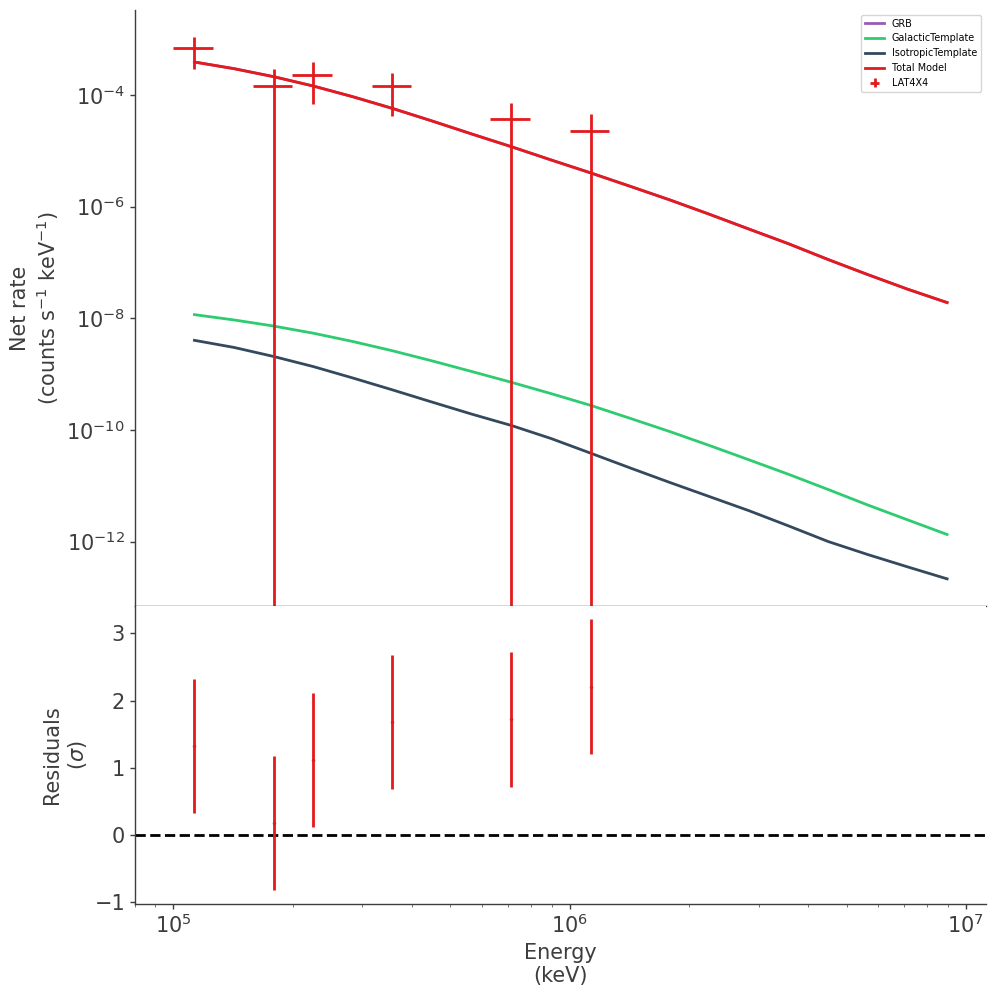

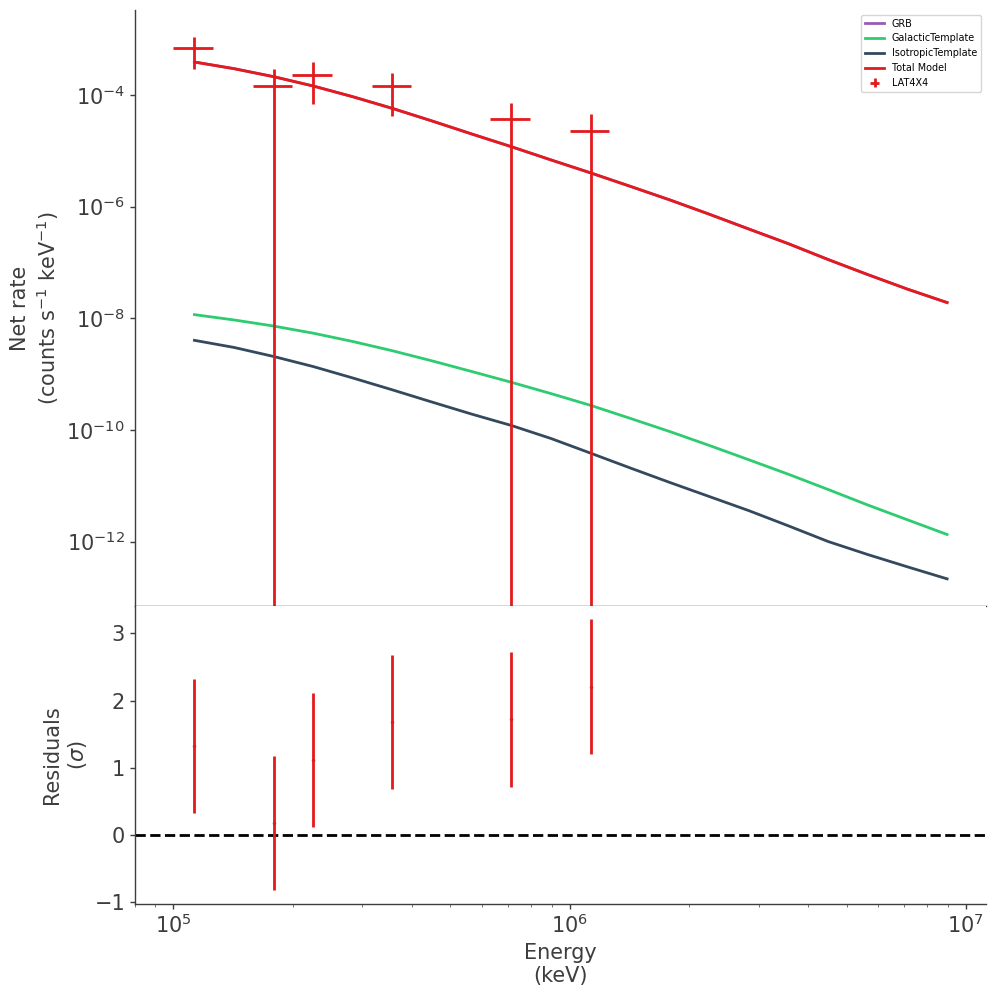

In [16]:
i = 3
T0, T1 = intervals[i], intervals[i + 1]
LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
jl = results[LAT_name]
jl.results.display()
display_spectrum_model_counts(jl, step=False, figsize=(10, 10))

We can see the evolution of the spectrum with time (not all the bins are diplayed):


processing MLE analyses:   0%|          | 0/13 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

02:20:14 DEBUG     converting MeV to MeV                                                          ]8;id=207886;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py\model_plot.py]8;;\:]8;id=331025;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py#890\890]8;;\

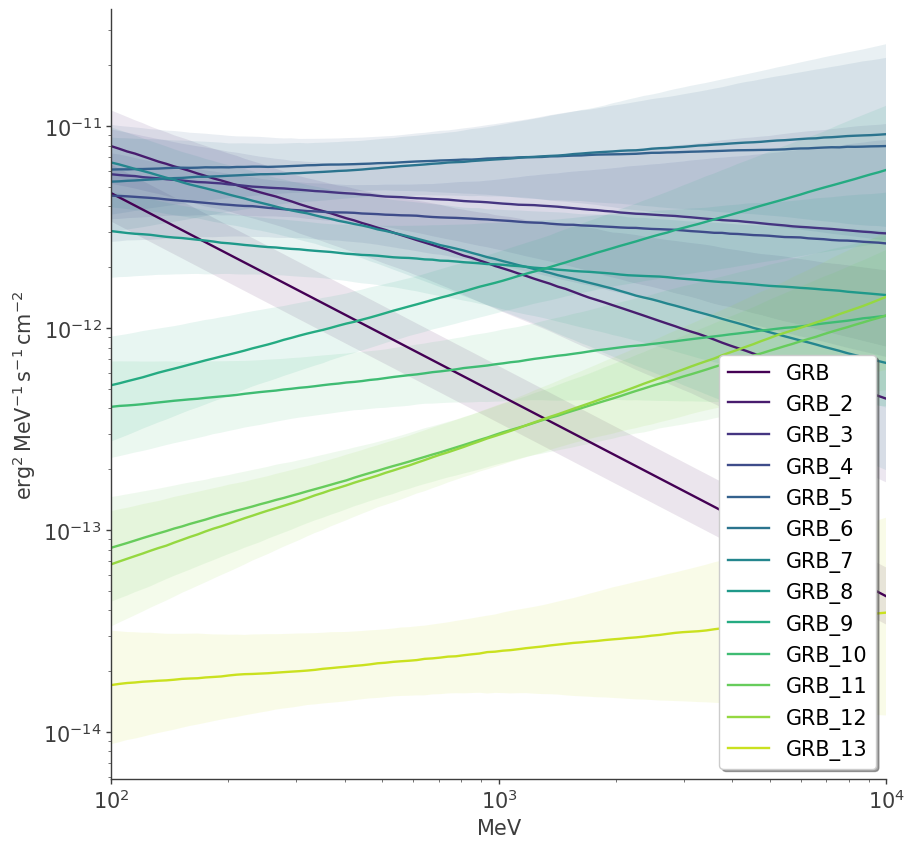

In [17]:
fig = plot_spectra(
    *[results[k].results for k in list(results.keys())[::2]],
    ene_min=100 * u.MeV,
    ene_max=10 * u.GeV,
    flux_unit="erg2/(cm2 s MeV)",
    energy_unit="MeV",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1)
)
fig.set_size_inches(10, 10)

Finally, we can display flux lightcurves and index evolution with time.


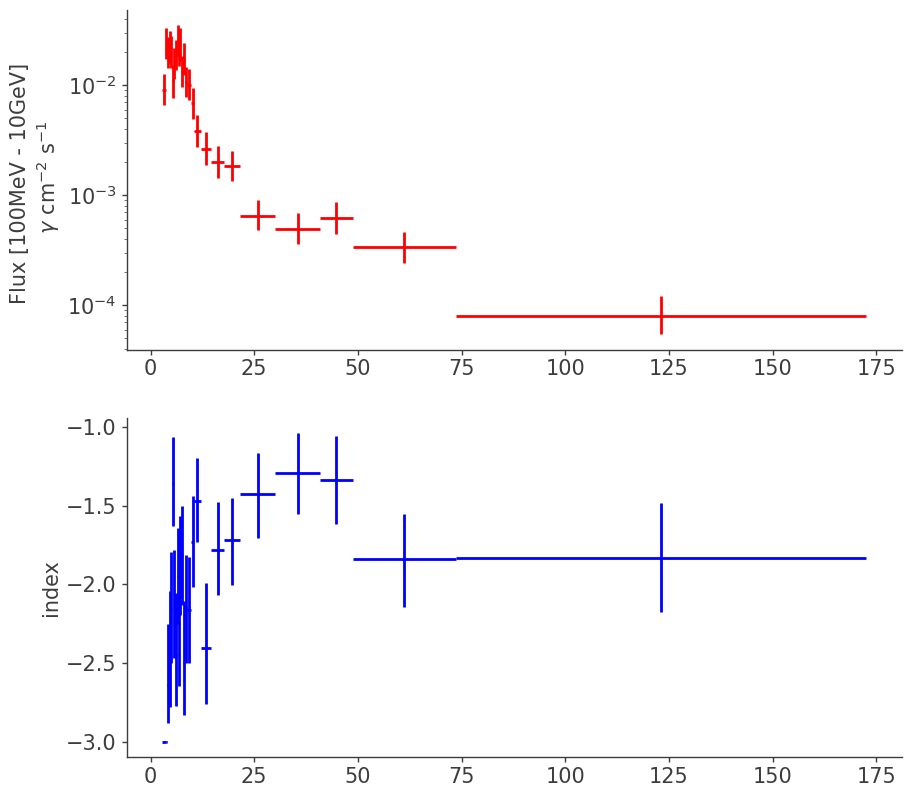

In [18]:
variates = ["F", "index"]
y = {}
for n in variates:
    y[n] = []
    y[n + "_p"] = []
    y[n + "_n"] = []
x = []
dx = []


for T0, T1 in zip(intervals[:-1], intervals[1:]):
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    x.append((T1 + T0) / 2)
    dx.append((T1 - T0) / 2)
    jl = results[LAT_name]
    res = jl.results
    mod = res.optimized_model
    ps = mod.point_sources

    for n in variates:
        my_variate = res.get_variates("GRB.spectrum.main.Powerlaw_flux.%s" % n)
        y[n].append(my_variate.median)
        y[n + "_p"].append(my_variate.equal_tail_interval()[1] - my_variate.median)
        y[n + "_n"].append(my_variate.median - my_variate.equal_tail_interval()[0])
        pass
    pass

fig = plt.figure(figsize=(10, 15))
colors = ["r", "b"]
ylabels = ["Flux [100MeV - 10GeV] \n $\gamma$ cm$^{-2}$ s$^{-1}$", "index"]
for i, n in enumerate(variates):
    plt.subplot(len(variates) + 1, 1, i + 1)
    plt.errorbar(x, y[n], xerr=dx, yerr=(y[n + "_n"], y[n + "_p"]), ls="", c=colors[i])
    if i == 0:
        plt.yscale("log")
    # plt.xscale('log')
    plt.ylabel(ylabels[i])
    pass